In [1]:
EXP_NAME = "xgboost_sample"

In [2]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import seaborn as sns

import pandas as pd

In [3]:
xgb.__version__

'3.0.0'

In [4]:
train = pl.read_csv("../../data/train.csv")
test = pl.read_csv("../../data/test.csv")

In [5]:
USE_COL = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
CATEGORICAL_FEATURE = ["Sex", "Embarked"]
TARGET_COL = "Survived"
FOLD_NUM = 5
SEED = 42

In [ ]:
# Categorical型への変換（XGBoostは内部でone-hotするか、エンコーディングを行う場合は別途処理が必要だが、
# ここでは単純なcastのみ行い、後続でpandas.get_dummies等でone-hotをすることを想定）
# enable_categoricalの指定で動きはするけれど、精度的に問題ないのか未確認である。
for cat_col in CATEGORICAL_FEATURE:
    train = train.with_columns(pl.col(cat_col).cast(pl.Categorical))
    test = test.with_columns(pl.col(cat_col).cast(pl.Categorical))

# # One-hotエンコーディング
# train_pd = train.to_pandas()
# test_pd = test.to_pandas()

# train_pd = pd.get_dummies(train_pd, columns=CATEGORICAL_FEATURE)
# test_pd = pd.get_dummies(test_pd, columns=CATEGORICAL_FEATURE)

In [7]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [8]:
train

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fold
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat,i64
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S""",2
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C""",4
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S""",1
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S""",2
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S""",4
…,…,…,…,…,…,…,…,…,…,…,…,…
887,0,2,"""Montvila, Rev. Juozas""","""male""",27.0,0,0,"""211536""",13.0,null,"""S""",0
888,1,1,"""Graham, Miss. Margaret Edith""","""female""",19.0,0,0,"""112053""",30.0,"""B42""","""S""",4
889,0,3,"""Johnston, Miss. Catherine Hele…","""female""",null,1,2,"""W./C. 6607""",23.45,null,"""S""",3


In [ ]:
import sys

sys.path.append("/root/atmacup19")
from src.feature_engineering.table import add_target_encoding

# Pclassごとのtarget encodingの実装
TARGET_ENCODING_COL = ["Pclass", "Sex"]

train, test, add_col = add_target_encoding(
    train, test, FOLD_NUM, TARGET_COL, TARGET_ENCODING_COL
)

USE_COL += add_col

In [10]:
# %%
# XGBoost用パラメータ設定
# LightGBMパラメータをXGBoostに近い形で換装:
# objective: binary → binary:logistic
# learning_rate: 0.01 → eta: 0.01
# feature_fraction: 0.9 → colsample_bytree:0.9
# bagging_fraction:0.8 → subsample:0.8
# lambda_l1:0.4 → reg_alpha:0.4
# lambda_l2:0.4 → reg_lambda:0.4
# min_data_in_leaf:10 → min_child_weight:10 (近似的対応)
# num_leaves:24 → XGBoostには直接対応するパラメータがないためmax_depth、max_leavesなどで調整が可能。
# ここではmax_depthに制約をかけず、大きめの値をとらせるか、auto設定とします。
params = {
    "objective": "binary:logistic",
    "eta": 0.01,
    "max_depth": 0,  # 実質的に制約なし
    "min_child_weight": 10,
    "colsample_bytree": 0.9,
    "subsample": 0.8,
    "verbosity": 1,  # ログは適宜表示
    "seed": SEED,
    "reg_alpha": 0.4,
    "reg_lambda": 0.4,
    # LightGBMのbagging_freqに相当するものはXGBoostには明示的にないが、
    # subsampleを繰り返し変えることで類似効果が期待できる。
}

NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 100
VERBOSE_EVAL = 100

In [11]:
models = []

# Cross Validationによる学習
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    X_train = train_fold[USE_COL]
    X_valid = valid_fold[USE_COL]
    y_train = train_fold[TARGET_COL]
    y_valid = valid_fold[TARGET_COL]

    dtrain = xgb.DMatrix(
        X_train.to_pandas(),
        label=y_train,
        feature_names=USE_COL,
        enable_categorical=True,
    )
    dvalid = xgb.DMatrix(
        X_valid.to_pandas(),
        label=y_valid,
        feature_names=USE_COL,
        enable_categorical=True,
    )

    # モデル学習
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dtrain, "train"), (dvalid, "eval")],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=VERBOSE_EVAL,
    )

    models.append([fold, model])

Start fold 0
[0]	train-logloss:0.65826	eval-logloss:0.67667
[100]	train-logloss:0.47411	eval-logloss:0.49432
[200]	train-logloss:0.42593	eval-logloss:0.45294
[300]	train-logloss:0.40418	eval-logloss:0.43901
[400]	train-logloss:0.38950	eval-logloss:0.43237
[500]	train-logloss:0.37859	eval-logloss:0.42904
[600]	train-logloss:0.36961	eval-logloss:0.42710
[700]	train-logloss:0.36223	eval-logloss:0.42527
[800]	train-logloss:0.35553	eval-logloss:0.42415
[900]	train-logloss:0.34981	eval-logloss:0.42371
[1000]	train-logloss:0.34447	eval-logloss:0.42456
[1045]	train-logloss:0.34211	eval-logloss:0.42508
Start fold 1
[0]	train-logloss:0.66258	eval-logloss:0.65891
[100]	train-logloss:0.46689	eval-logloss:0.49954
[200]	train-logloss:0.41707	eval-logloss:0.46782
[300]	train-logloss:0.39467	eval-logloss:0.45953
[400]	train-logloss:0.38019	eval-logloss:0.45663
[500]	train-logloss:0.36953	eval-logloss:0.45532
[600]	train-logloss:0.36056	eval-logloss:0.45201
[700]	train-logloss:0.35356	eval-logloss:0.45

In [12]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    dvalid = xgb.DMatrix(
        X_valid.to_pandas(),
        label=y_valid,
        feature_names=USE_COL,
        enable_categorical=True,
    )

    # validデータに対する推論
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    y_valid_pred = (y_valid_pred > 0.5).astype(int)

    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.7914414414414415
fold 1 Score: 0.7534624176415221
fold 2 Score: 0.8436507936507937
fold 3 Score: 0.7521645021645021
fold 4 Score: 0.8140231449965963


In [13]:
oof_score = roc_auc_score(train[TARGET_COL], oof)
oof_score

np.float64(0.7919902214552776)

<Axes: >

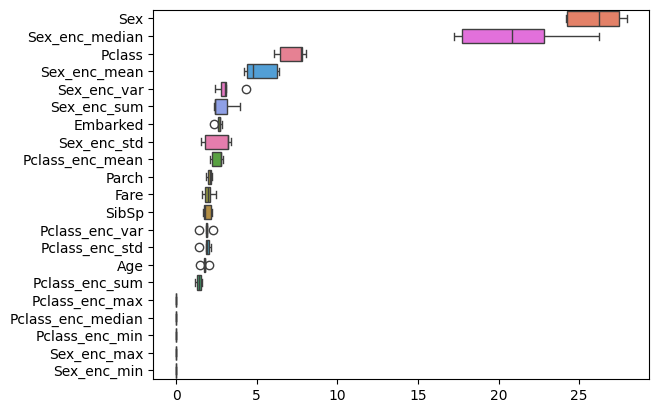

In [14]:
# 特徴量重要度
# XGBoostではmodel.get_score(importance_type='gain')で特徴重要度が取得できる
# 戻り値はdict形式なのでDataFrameに変換する
feature_importances = []
for _, model in models:
    score_dict = model.get_score(importance_type="gain")
    # 全ての列についてスコアがない場合は0で補完する
    row = [score_dict.get(col, 0.0) for col in USE_COL]
    feature_importances.append(row)

feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [15]:
# テストデータに対する予測
dtest = xgb.DMatrix(
    test[USE_COL].to_pandas(), feature_names=USE_COL, enable_categorical=True
)
pred = []
for _, model in models:
    p = model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    pred.append(p)
pred = np.mean(pred, axis=0)
pred = (pred > 0.5).astype(int)

# predに推論結果が入っている
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [16]:
submit_df = pl.DataFrame({"PassengerId": test["PassengerId"], "Survived": pred})
submit_df.write_csv(f"../../submit/{EXP_NAME}_oof{oof_score:.4f}.csv")

FileNotFoundError: No such file or directory (os error 2): ../../submit/xgboost_sample_oof0.7920.csv

In [ ]:
oof_score
# tar_encなしのoofは0.8090, LBは0.7461
# tar_encありのoofは0.7944, LBは0.7584
# 微妙、そもそもスコアが低すぎる気がする。LGBMの場合は、LB0.78程度までは行く。

In [ ]:
submit_df